# Differences between DPI and MDI Inhaler Prescribing in England: Update to provide 10 years of data

 <a id='Intro'></a>
### Introduction
This is an addendum to a [previous notebook](https://github.com/ebmdatalab/prescribing-notebooks/blob/master/notebooks/Final_ACT_Environment_inhaler_2023_Prescribing-V2_SQL.ipynb) where a step by step analysis was completed for 2023 data This updates the query to provide the last 10 complete past years.

<a id='setup'></a>
### Setting Up Our Tools

In [1]:
# Import the libraries we need:
from ebmdatalab import bq                  # Connects us to the prescribing database
import pandas as pd                        # Our main tool for handling data tables
import matplotlib.pyplot as plt           # Creates charts and graphs
import matplotlib.ticker as mtick
import numpy as np                         # Helps with numerical calculations
import os                                  # Manages file paths

# This setting ensures we can see full product names in our results
pd.set_option('display.max_colwidth', None)



### Extracting 2016 to 2025 Prescribing Data

We'll gather all relevant prescribing data from between 2016 to 2025. We'll organise this data to include:

-   **Year** (DPI/MDI/SMI)
-   **Device type** (DPI/MDI/SMI)
-   **Therapeutic class** (based on ATC codes):

    -   **SABA** (Short-acting beta-agonists): `R03AC0`

    -   **LABA** (Long-acting beta-agonists): `R03AC1`

    -   **Anticholinergic medications**: `R03BB`

    -   **ICS** (Inhaled corticosteroids): `R03BA`

    -   **Combi_1**: Adrenergics combined with corticosteroids or other drugs (excluding anticholinergics): `R03AK`

    -   **Combi_2**: Adrenergics combined with anticholinergics, including triple combinations with corticosteroids: `R03AL`

    -   **Other**: Any medications not falling into the above categories---useful for checking data quality. 
 
In this SQL query, we will also add special handing for the Generic Enerzair Breezhaler which doesn't have an ATC code, as identified in the [previous notebook](https://github.com/ebmdatalab/prescribing-notebooks/blob/master/notebooks/Final_ACT_Environment_inhaler_2023_Prescribing-V2_SQL.ipynb).

In [2]:
sql_all_resp_inhaler_rx_with_atc_code_10yr = """
WITH resp_inhalers AS (
  SELECT
    EXTRACT(YEAR FROM month) AS year,
    rx.bnf_code,
    rx.bnf_name,
    CASE
      WHEN vmp.id = 39134511000001107 THEN 'R03AL12'
      ELSE atc.atc_code
    END AS atc_code,
    CASE 
      WHEN r.descr = 'powderinhalation.inhalation' THEN 'DPI'
      WHEN r.descr = 'pressurizedinhalation.inhalation' THEN 'MDI'
      WHEN r.descr = 'inhalationsolution.inhalation' THEN 'SMI'
    ELSE 'OTHER' END AS type,
    SUM(items) AS total_items
  FROM `hscic.normalised_prescribing` rx
  LEFT JOIN `dmd.vmp` vmp ON CONCAT(SUBSTR(rx.bnf_code,0,9),SUBSTR(rx.bnf_code,-2)) = 
                             CONCAT(SUBSTR(vmp.bnf_code,0,9),SUBSTR(vmp.bnf_code,-2))
  LEFT JOIN `dmd.ont` AS o ON vmp.id = o.vmp
  LEFT JOIN `dmd.ontformroute` AS r ON o.form = r.cd
  LEFT JOIN `scmd.scmd_dmd_supp` AS atc ON CAST(vmp.id AS STRING) = atc.vmp_code
  WHERE EXTRACT(YEAR FROM month) BETWEEN 2016 AND 2025
    AND vmp.bnf_code LIKE '03%'
    AND r.descr IN (
      'powderinhalation.inhalation',
      'pressurizedinhalation.inhalation',
      'inhalationsolution.inhalation'
    )
  GROUP BY year, bnf_code, bnf_name, atc_code, type
  ORDER BY total_items DESC
)

SELECT 
  year,
  bnf_code,
  bnf_name,
  atc_code,
  CASE
    WHEN SUBSTR(atc_code,0,6) = 'R03AC0' THEN 'SABA'
    WHEN SUBSTR(atc_code,0,6) = 'R03AC1' THEN 'LABA'
    WHEN SUBSTR(atc_code,0,5) = 'R03BB' THEN 'Anticholinergic'
    WHEN SUBSTR(atc_code,0,5) = 'R03BA' THEN 'ICS'
    WHEN SUBSTR(atc_code,0,5) = 'R03AK' THEN 'Combi_1'
    WHEN SUBSTR(atc_code,0,5) = 'R03AL' THEN 'Combi_2'
    ELSE 'OTHER'
  END AS cat,
  type,
  total_items
FROM resp_inhalers
"""
all_resp_inhaler_rx_with_atc_code_10yr = bq.cached_read(
    sql_all_resp_inhaler_rx_with_atc_code_10yr,
    csv_path=os.path.join('..', 'data', '10_year_inhaler_data', 'Final_all_resp_inhaler_rx_with_atc_code_10yr.csv')
)

Downloading: 100%|█████████████████████████████████████████████████████████████|


**This query will process 180.29 GB when run.**

In [3]:
display(all_resp_inhaler_rx_with_atc_code_10yr.head(10))

,year,bnf_code,bnf_name,atc_code,cat,type,total_items
0,2020,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,12952597
1,2019,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,12534593
2,2021,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,12309571
3,2017,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,12309543
4,2016,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,12250150
5,2018,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,12215290
6,2022,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,10872399
7,2024,0301011R0BIAFAP,Salamol 100micrograms/dose inhaler CFC free (Teva),R03AC02,SABA,MDI,8282376
8,2023,0301011R0BIAFAP,Salamol 100micrograms/dose inhaler CFC free (Teva),R03AC02,SABA,MDI,7373702
9,2023,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,7315130



### Breakdown prescribing by ATC Category

Now that we have grouped products into clinically meaningful groups, we then calculate the percentage of items delivered as DPI in each Category.


In [4]:
sql_DPI_uptake_by_ATC_cluster = """
WITH resp_inhalers AS (
  SELECT
    EXTRACT(YEAR FROM month) AS year,
    rx.bnf_code,                    
    rx.bnf_name,                    
    CASE
      WHEN vmp.id = 39134511000001107 THEN 'R03AL12'
      ELSE atc.atc_code
    END AS atc_code,
    CASE 
      WHEN r.descr = 'powderinhalation.inhalation' THEN 'DPI'    
      WHEN r.descr = 'pressurizedinhalation.inhalation' THEN 'MDI' 
      WHEN r.descr = 'inhalationsolution.inhalation' THEN 'SMI'   
    ELSE 'OTHER' END AS type,
    SUM(items) AS total_items
  FROM hscic.normalised_prescribing rx
  LEFT JOIN dmd.vmp vmp ON CONCAT(SUBSTR(rx.bnf_code,0,9),SUBSTR(rx.bnf_code,-2)) = 
                             CONCAT(SUBSTR(vmp.bnf_code,0,9),SUBSTR(vmp.bnf_code,-2))
  LEFT JOIN dmd.ont AS o ON vmp.id = o.vmp
  LEFT JOIN dmd.ontformroute AS r ON o.form = r.cd
  LEFT JOIN scmd.scmd_dmd_supp AS atc ON CAST(vmp.id AS STRING) = atc.vmp_code
  WHERE EXTRACT(YEAR FROM month) BETWEEN 2016 AND 2025         
    AND vmp.bnf_code LIKE '03%'                 
    AND r.descr IN (                            
      'powderinhalation.inhalation',            
      'pressurizedinhalation.inhalation',       
      'inhalationsolution.inhalation'           
    )
  GROUP BY year, bnf_code, bnf_name, atc_code, type
  ORDER BY total_items DESC
)
SELECT 
  year,
  CASE
    WHEN SUBSTR(atc_code,0,6) = 'R03AC0' THEN 'SABA'
    WHEN SUBSTR(atc_code,0,6) = 'R03AC1' THEN 'LABA'
    WHEN SUBSTR(atc_code,0,5) = 'R03BB' THEN 'Anticholinergic'
    WHEN SUBSTR(atc_code,0,5) = 'R03BA' THEN 'ICS'
    WHEN SUBSTR(atc_code,0,5) = 'R03AK' THEN 'Combi_1'
    WHEN SUBSTR(atc_code,0,5) = 'R03AL' THEN 'Combi_2'
    ELSE 'Other'
  END AS cluster,          
  
  SUM(CASE WHEN type = 'DPI' THEN total_items ELSE 0 END) AS DPI,
  SUM(CASE WHEN type = 'MDI' THEN total_items ELSE 0 END) AS MDI, 
  SUM(CASE WHEN type = 'SMI' THEN total_items ELSE 0 END) AS SMI,
  
  ROUND(
    100.0 * SUM(CASE WHEN type = 'DPI' THEN total_items ELSE 0 END) / 
    SUM(total_items), 
    1
  ) AS DPI_percentage
  
FROM resp_inhalers         
GROUP BY 
  year,
  CASE
    WHEN SUBSTR(atc_code,0,6) = 'R03AC0' THEN 'SABA'
    WHEN SUBSTR(atc_code,0,6) = 'R03AC1' THEN 'LABA'
    WHEN SUBSTR(atc_code,0,5) = 'R03BB' THEN 'Anticholinergic'
    WHEN SUBSTR(atc_code,0,5) = 'R03BA' THEN 'ICS'
    WHEN SUBSTR(atc_code,0,5) = 'R03AK' THEN 'Combi_1'
    WHEN SUBSTR(atc_code,0,5) = 'R03AL' THEN 'Combi_2'
    ELSE 'Other'
  END
ORDER BY cluster, year
"""
DPI_uptake_by_ATC_cluster = bq.cached_read(
 sql_DPI_uptake_by_ATC_cluster,
    csv_path=os.path.join('..', 'data', '10_year_inhaler_data',' Final_DPI_uptake_by_ATC_cluster.csv')
) 

Downloading: 100%|█████████████████████████████████████████████████████████████|


**This query will process 180.29 GB when run.**

In [5]:
display(DPI_uptake_by_ATC_cluster)

,year,cluster,DPI,MDI,SMI,DPI_percentage
0,2016,Anticholinergic,5143812,500600,555051,83.0
1,2017,Anticholinergic,5108483,419816,717481,81.8
2,2018,Anticholinergic,4805265,344862,911991,79.3
3,2019,Anticholinergic,4045009,281500,1008215,75.8
4,2020,Anticholinergic,3430756,234043,1120577,71.7
...,...,...,...,...,...,...
65,2021,SABA,1131429,19711876,0,5.4
66,2022,SABA,1354779,20032591,0,6.3
67,2023,SABA,1665854,19311597,0,7.9
68,2024,SABA,1740676,18644358,0,8.5


### Visualising Our Findings


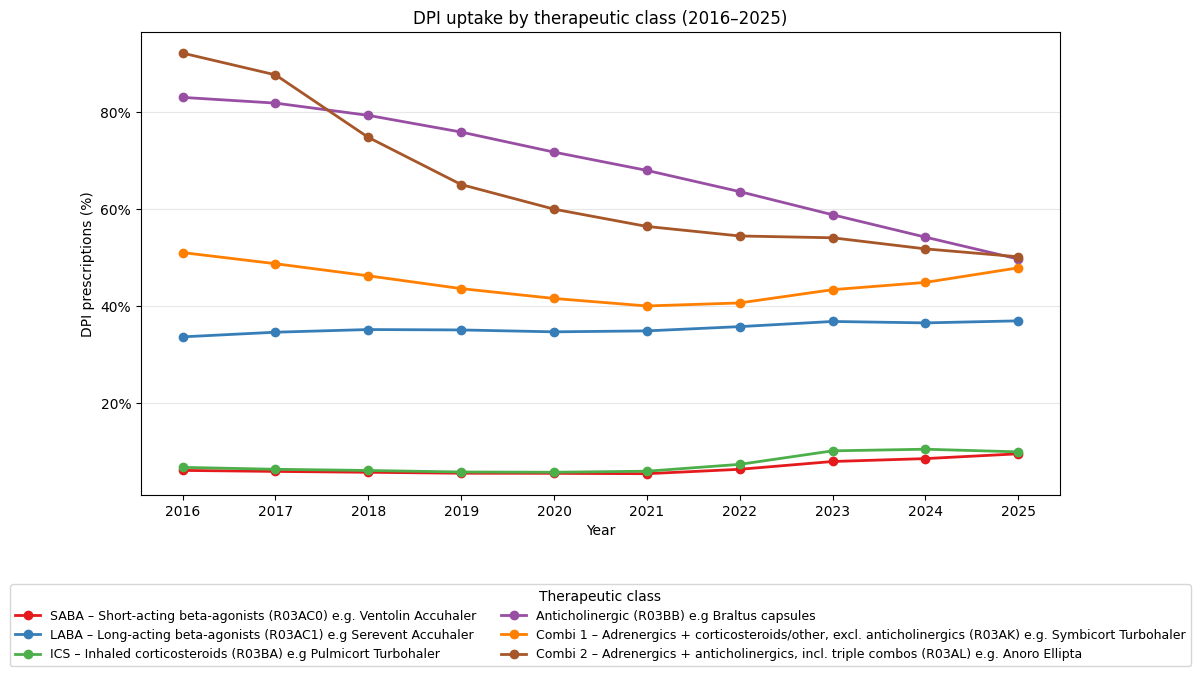

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Aggregate by year, cat and type
yearly_cat = all_resp_inhaler_rx_with_atc_code_10yr.groupby(
    ['year', 'cat', 'type']
)['total_items'].sum().reset_index()

yearly_totals = yearly_cat.groupby(['year', 'cat'])['total_items'].sum().reset_index(name='cat_total')
yearly_dpi = yearly_cat[yearly_cat['type'] == 'DPI'].groupby(['year', 'cat'])['total_items'].sum().reset_index(name='dpi_total')

dpi_pct = yearly_totals.merge(yearly_dpi, on=['year', 'cat'], how='left')
dpi_pct['dpi_total'] = dpi_pct['dpi_total'].fillna(0)
dpi_pct['dpi_pct'] = 100 * dpi_pct['dpi_total'] / dpi_pct['cat_total']

# Plot
fig, ax = plt.subplots(figsize=(12, 7))

categories = ['SABA', 'LABA', 'ICS', 'Anticholinergic', 'Combi_1', 'Combi_2']
colours = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628']

# Full descriptions for legend
labels = {
    'SABA': 'SABA – Short-acting beta-agonists (R03AC0) e.g. Ventolin Accuhaler',
    'LABA': 'LABA – Long-acting beta-agonists (R03AC1) e.g Serevent Accuhaler',
    'ICS': 'ICS – Inhaled corticosteroids (R03BA) e.g Pulmicort Turbohaler',
    'Anticholinergic': 'Anticholinergic (R03BB) e.g Braltus capsules',
    'Combi_1': 'Combi 1 – Adrenergics + corticosteroids/other, excl. anticholinergics (R03AK) e.g. Symbicort Turbohaler',
    'Combi_2': 'Combi 2 – Adrenergics + anticholinergics, incl. triple combos (R03AL) e.g. Anoro Ellipta',
}

for cat, colour in zip(categories, colours):
    data = dpi_pct[dpi_pct['cat'] == cat].sort_values('year')
    if not data.empty:
        ax.plot(data['year'], data['dpi_pct'], marker='o', label=labels[cat], color=colour, linewidth=2)

ax.set_xlabel('Year')
ax.set_ylabel('DPI prescriptions (%)')
ax.set_title('DPI uptake by therapeutic class (2016–2025)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_xticks(range(2016, 2026))
ax.grid(axis='y', alpha=0.3)

# Legend below the chart in two columns
ax.legend(
    title='Therapeutic class',
    bbox_to_anchor=(0.5, -0.18),
    loc='upper center',
    ncol=2,
    fontsize=9
)

plt.tight_layout()
plt.show()

## Quality Assurance - Checking Our Classifications
Finally, we validate our therapeutic groupings by reviewing the products assigned to the “Other” category. This helps us identify any products that may have been missed by the classification logic and determine whether they should be incorporated into the main case statement. For example, during our review of the 2023 data, we identified Generic Enerzair Breezhaler as incorrectly placed in the Other category and subsequently reassigned it.

In addition, we will review the top 10 most prescribed inhalers within each category to ensure the classifications align with expectations and to identify any anomalies.

In [10]:
other_category = all_resp_inhaler_rx_with_atc_code_10yr[
    all_resp_inhaler_rx_with_atc_code_10yr['cat'] == 'OTHER'
]
#display without truncation
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(other_category)

,year,bnf_code,bnf_name,atc_code,cat,type,total_items
1509,2018,0303010Q0AAANAN,Sodium cromoglicate 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,5130
1522,2019,0303010Q0AAANAN,Sodium cromoglicate 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,4946
1531,2020,0303010Q0AAANAN,Sodium cromoglicate 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,4745
1534,2016,0303010Q0AAANAN,Sodium cromoglicate 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,4679
1535,2017,0303010Q0AAANAN,Sodium cromoglicate 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,4676
1564,2021,0303010Q0AAANAN,Sodium cromoglicate 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,3919
1587,2016,0303010J0AAADAD,Nedocromil 2mg/dose inhaler CFC free,R03BC03,OTHER,MDI,3184
1613,2017,0303010J0AAADAD,Nedocromil 2mg/dose inhaler CFC free,R03BC03,OTHER,MDI,2699
1635,2018,0303010Q0BBALAN,Intal 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,2420
1649,2019,0303010Q0BBALAN,Intal 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,2266


An examination of the above list shows that no unexpected products appear in the other category.

In [8]:
top_10_inhaler_prescribing_per_cluster_10yr = (
    all_resp_inhaler_rx_with_atc_code_10yr
    .sort_values('total_items', ascending=False)
    .groupby(['year', 'cat'])
    .head(10)
    .sort_values(['year', 'cat', 'total_items'], ascending=[True, True, False])
    .reset_index(drop=True)
)

top_10_inhaler_prescribing_per_cluster_10yr.to_csv(
    os.path.join('..', 'data', '10_year_inhaler_data', 'interim_file_top_10_inhaler_prescribing_per_cluster_10yr.csv'),
    index=False
)

In [9]:
#display without truncation
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(top_10_inhaler_prescribing_per_cluster_10yr)

,year,bnf_code,bnf_name,atc_code,cat,type,total_items
0,2016,0301020Q0AAABAB,Tiotropium bromide 18microgram inhalation powder capsules,R03BB04,Anticholinergic,DPI,3336211
1,2016,0301020Q0AAAAAA,Tiotropium bromide 18microgram inhalation pdr caps with dev,R03BB04,Anticholinergic,DPI,518858
2,2016,0301020I0AAANAN,Ipratropium bromide 20micrograms/dose inhaler CFC free,R03BB01,Anticholinergic,MDI,436841
3,2016,0301020Q0AAACAC,Tiotropium brom 2.5microg/dose soln for inhalation CFCfree,R03BB04,Anticholinergic,SMI,338189
4,2016,0301020Q0BBABAB,Spiriva 18microgram inhalation powder capsules,R03BB04,Anticholinergic,DPI,272570
5,2016,0301020S0BBAAAA,Seebri Breezhaler 44microgram inhalation pdr caps with dev,R03BB06,Anticholinergic,DPI,250601
6,2016,0301020Q0BBACAC,Spiriva Respimat 2.5microg/dose inhalation soln,R03BB04,Anticholinergic,SMI,216862
7,2016,0301020R0BBAAAA,Eklira 322micrograms/dose Genuair,R03BB05,Anticholinergic,DPI,198558
8,2016,0301020T0BBAAAA,Incruse Ellipta 55micrograms/dose dry powder inhaler,R03BB07,Anticholinergic,DPI,197009
9,2016,0301020R0AAAAAA,Aclidinium bromide 375micrograms/dose dry powder inhaler,R03BB05,Anticholinergic,DPI,142676


Examination of the above list does not identify any omissions.

## End of Notebook